<a href="https://colab.research.google.com/github/YairYarden/Deep-Learning/blob/sub-feature%2FQ3_VAE/Q3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is influenced by [This](TODO : Add reference) forum


# Imports

In [57]:
import numpy as np
from datetime import datetime 
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.svm import SVC # For SVM

%load_ext tensorboard

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DIR_PATH = '/content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526'


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
CUDA is not available.  Training on CPU ...


# Mount Google Drive

In [58]:
from google.colab import drive
drive.mount('/content/drive/')

drive_path = '/content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526'

# Path for check point
ckpts_path = os.path.join(drive_path, 'Q3_VAE', 'checkpoints')
os.makedirs(ckpts_path, exist_ok=True)

print('Drive Path : ' + drive_path)
print('Check points Path : ' + ckpts_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive Path : /content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526
Check points Path : /content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526/Q3_VAE/checkpoints


# Functions for data loading

In [59]:
def get_train_samplers(labels, n:int):
    """
    return 2 samplers of the train data, one for the labeled and one for the unlabeled data.

    Args:
        labels: array of all the labels in the dataset.
        n: number of labeled elements
    """
    n_classes = int(np.max(labels) + 1)
    n_per_class = n // n_classes


    labeled_indices = []
    unlabeled_indices = []

    for i in range(n_classes):
        curr_label_indices = np.where(labels==i)[0]
        labeled_indices.extend(curr_label_indices[:n_per_class].tolist())
        unlabeled_indices.extend(curr_label_indices[n_per_class:].tolist())

    return SubsetRandomSampler(labeled_indices), SubsetRandomSampler(unlabeled_indices)


def get_dataloaders(n, batch_size, num_workers=2):
    labeled_sampler, unlabeld_sampler = get_train_samplers(train_labels, n)
    train_labeled = DataLoader(train_dataset,
                               batch_size=batch_size,
                               sampler=labeled_sampler,
                               num_workers=num_workers,
                               pin_memory=True)
    

    train_unlabeled = DataLoader(train_dataset,
                                 batch_size=batch_size,
                                 sampler=unlabeld_sampler,
                                 num_workers=num_workers,
                                 pin_memory=True)
    
    test = DataLoader(test_dataset,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        pin_memory=True)
    
    return train_labeled, train_unlabeled, test

# Load Data

In [60]:
# Define transform
transform = transforms.Compose([transforms.ToTensor()])

# Load Dataset
train_dataset = datasets.FashionMNIST(root=os.path.join(drive_path), 
                               train=True, 
                               transform=transform,
                               download=True,)

train_labels = np.array([label for _, label in train_dataset])

test_dataset = datasets.FashionMNIST(root=os.path.join(drive_path), 
                               train=False, 
                               transform=transform)


# Visualize a batch of training data


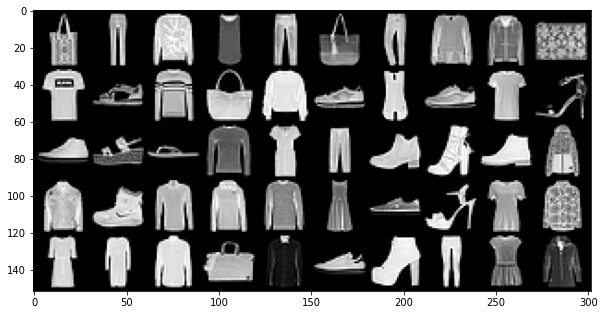

In [61]:
train_labeled, _, _ = get_dataloaders(n=50, batch_size=50)
dataiter = iter(train_labeled)
images, labels = dataiter.next()

plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=images, nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");

# Define VAE Model

In [62]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))

        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Functions for Training

## Loss Function

In [63]:
def vae_loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

    

## Plotting

In [64]:
def plot_vae_sampels(vea_model, n=3):
    fig, axs = plt.subplots(1,n, figsize=[10,5])
    with torch.no_grad():
        z = torch.randn(n, 50, device=DEVICE)
        sample = vea_model.decoder(z).cpu()
    
    for i, ax in enumerate(axs):
        ax.imshow(sample[i].view([28,28]), cmap='gray')
        ax.axis('off')

    plt.tight_layout()

    plt.show()

## Train Epoch

In [65]:
def train_vae_epoch(vae_model, train_loader, optimizer, epoch_idx):
    vae_model.train()
    train_loss = 0
    num_samples = 0

    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae_model(data)
        loss = vae_loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        num_samples += data.shape[0]
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_idx, batch_idx, len(train_loader),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
            
    avg_loss = train_loss / num_samples
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch_idx, avg_loss))

    return avg_loss

## Train Full

In [66]:
def train_vae(train_loader, test_loader, epochs, lr=1e-3, patience=3):
    vae = VAE(x_dim=784, h_dim1= 600, h_dim2=600, z_dim=50).to(DEVICE)
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    min_loss = np.inf
    unchanged_min_loss = 0
    for epoch in range(1, epochs+1):
        curr_loss = train_vae_epoch(vae_model=vae,
                                    train_loader=train_loader, 
                                    optimizer=optimizer,
                                    epoch_idx=epoch)
        
        plot_vae_sampels(vae,5)
        
        if curr_loss <  min_loss:
            min_loss = curr_loss
            unchanged_min_loss = 0

        else:
            print('updating unchanged_min_loss')
            unchanged_min_loss += 1

        
        if unchanged_min_loss == patience:
            print(f'loss has not imporoved for {patience} epochs. stoping training.')

    return vae


## Test

In [67]:
def test_vae(vae_model, test_loader):
    vae_model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)
            recon, mu, log_var = vae_model(data)
            
            # sum up batch loss
            test_loss += vae_loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss.item()

# Define SVM Model

## Encode 

In [68]:
def encode_data(data_loader, vae_model):
    """
    encode all the data in a data_loader and stack it, ready for svm training
    """
    vae_model.eval()
    vae_model.to(DEVICE)

    mus = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            mu, _ = vae_model.encoder(x.view(-1, 28**2))
            mus.append(mu)
            labels.extend(y.tolist())

        encoded_data = torch.cat(mus)

    return encoded_data.cpu().numpy(), np.asarray(labels)

## Train

In [69]:
def train_svm(train_loader, vae_model):
    encoded_data, labels = encode_data(train_loader, vae_model)
    
    svm = SVC()
    svm.fit(encoded_data, labels)

    return svm

## Compute Classification Error

In [70]:
def clasification_error(svm_model, vae_model, test_loader):
    encoded_data, labels = encode_data(test_loader, vae_model)
    acc_score = svm_model.score(encoded_data, labels)

    return (1 - acc_score) * 100

# M1 Scheme

In [71]:
def m1_scheme(n:int, 
              batch_size=128,
              epochs=10,
              lr=3e-4):
    """
    implement the M1 scheme from the paper. 

    n: number of labeled data

    returns: 
        error, vae, svm
    """
    train_labeled_loader, train_unlabeled_loader, test_loader = get_dataloaders(n=n,
                                                                                batch_size=batch_size)

    print('Training the VAE...')
    vae = train_vae(train_unlabeled_loader, test_loader, epochs, lr)

    print('Training the SVM...')
    svm = train_svm(train_labeled_loader, vae)

    print('Conmputing error')
    error = clasification_error(svm, vae, test_loader)
    
    return error, vae, svm


# Functions for Save & Load Model

In [72]:
import pickle

def save_models(vae, svm, name):
    vae_path = os.path.join(ckpts_path, f'{name}_vae.ckpt')
    svm_path = os.path.join(ckpts_path, f'{name}_svm.pkl')

    torch.save({'model_state_dict': vae.state_dict()}, vae_path)

    with open(svm_path, 'wb') as f:
        pickle.dump(svm, f)

def load_models(name):
    """
    returns vae and svm
    """
    vae_path = os.path.join(ckpts_path, f'{name}_vae.ckpt')
    svm_path = os.path.join(ckpts_path, f'{name}_svm.pkl')

    checkpoint = torch.load(vae_path)
    vae = VAE(x_dim=784, h_dim1= 600, h_dim2=600, z_dim=50)
    vae.load_state_dict(checkpoint['model_state_dict'])

    with open(svm_path, 'rb') as f:
        svm = pickle.load(f)

    return vae, svm

# Train The Network

---------- n=100 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/468 (0%)]	Loss: 543.923889
Train Epoch: 1 [batch: 100/468 (21%)]	Loss: 310.043274
Train Epoch: 1 [batch: 200/468 (43%)]	Loss: 306.124847
Train Epoch: 1 [batch: 300/468 (64%)]	Loss: 286.180878
Train Epoch: 1 [batch: 400/468 (85%)]	Loss: 287.322296
====> Epoch: 1 Average loss: 309.8758


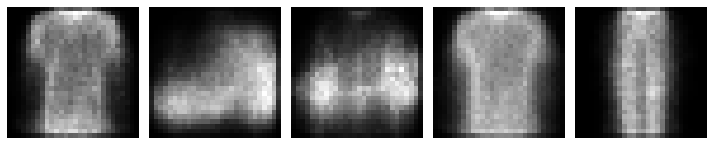

Train Epoch: 2 [batch: 0/468 (0%)]	Loss: 272.292755
Train Epoch: 2 [batch: 100/468 (21%)]	Loss: 271.107849
Train Epoch: 2 [batch: 200/468 (43%)]	Loss: 268.170197
Train Epoch: 2 [batch: 300/468 (64%)]	Loss: 268.332825
Train Epoch: 2 [batch: 400/468 (85%)]	Loss: 269.236481
====> Epoch: 2 Average loss: 265.6625


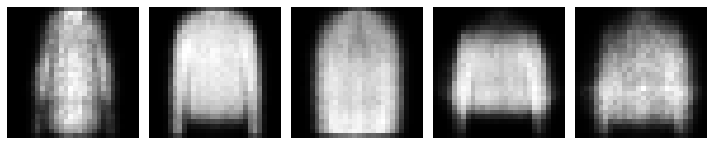

Train Epoch: 3 [batch: 0/468 (0%)]	Loss: 261.799774
Train Epoch: 3 [batch: 100/468 (21%)]	Loss: 255.896194
Train Epoch: 3 [batch: 200/468 (43%)]	Loss: 256.760620
Train Epoch: 3 [batch: 300/468 (64%)]	Loss: 246.904068
Train Epoch: 3 [batch: 400/468 (85%)]	Loss: 249.591461
====> Epoch: 3 Average loss: 256.5433


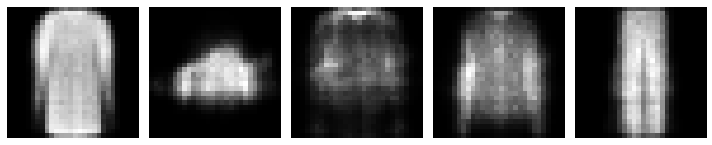

Train Epoch: 4 [batch: 0/468 (0%)]	Loss: 249.975037
Train Epoch: 4 [batch: 100/468 (21%)]	Loss: 246.362350
Train Epoch: 4 [batch: 200/468 (43%)]	Loss: 247.978851
Train Epoch: 4 [batch: 300/468 (64%)]	Loss: 268.232422
Train Epoch: 4 [batch: 400/468 (85%)]	Loss: 258.114349
====> Epoch: 4 Average loss: 251.5016


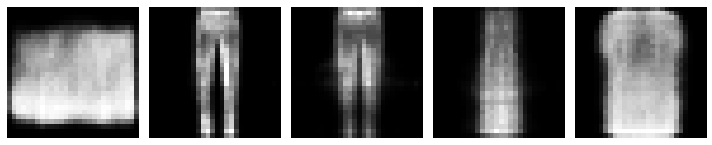

Train Epoch: 5 [batch: 0/468 (0%)]	Loss: 248.115753
Train Epoch: 5 [batch: 100/468 (21%)]	Loss: 255.846466
Train Epoch: 5 [batch: 200/468 (43%)]	Loss: 246.132385
Train Epoch: 5 [batch: 300/468 (64%)]	Loss: 242.026718
Train Epoch: 5 [batch: 400/468 (85%)]	Loss: 250.674393
====> Epoch: 5 Average loss: 248.6709


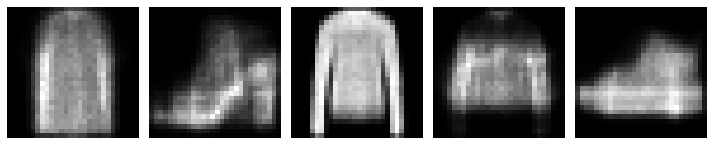

Training the SVM...
Conmputing error
---------- n=600 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/465 (0%)]	Loss: 544.543762
Train Epoch: 1 [batch: 100/465 (22%)]	Loss: 314.926422
Train Epoch: 1 [batch: 200/465 (43%)]	Loss: 306.529205
Train Epoch: 1 [batch: 300/465 (65%)]	Loss: 293.490326
Train Epoch: 1 [batch: 400/465 (86%)]	Loss: 297.682037
====> Epoch: 1 Average loss: 310.8236


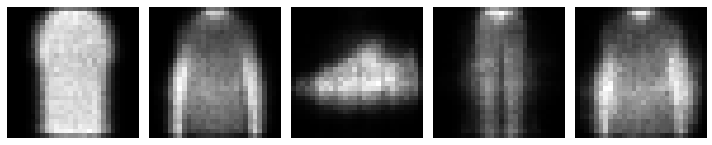

Train Epoch: 2 [batch: 0/465 (0%)]	Loss: 278.113708
Train Epoch: 2 [batch: 100/465 (22%)]	Loss: 268.739288
Train Epoch: 2 [batch: 200/465 (43%)]	Loss: 278.894073
Train Epoch: 2 [batch: 300/465 (65%)]	Loss: 258.187378
Train Epoch: 2 [batch: 400/465 (86%)]	Loss: 263.317810
====> Epoch: 2 Average loss: 266.0125


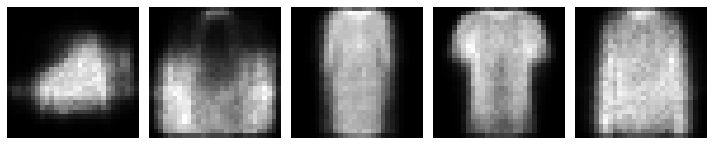

Train Epoch: 3 [batch: 0/465 (0%)]	Loss: 268.198303
Train Epoch: 3 [batch: 100/465 (22%)]	Loss: 257.191620
Train Epoch: 3 [batch: 200/465 (43%)]	Loss: 261.655457
Train Epoch: 3 [batch: 300/465 (65%)]	Loss: 249.698929
Train Epoch: 3 [batch: 400/465 (86%)]	Loss: 243.406082
====> Epoch: 3 Average loss: 256.8531


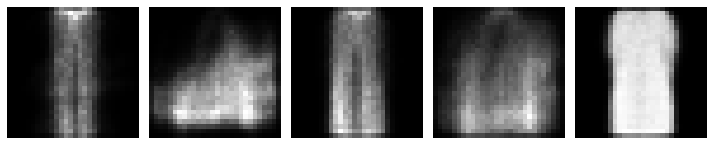

Train Epoch: 4 [batch: 0/465 (0%)]	Loss: 248.176712
Train Epoch: 4 [batch: 100/465 (22%)]	Loss: 254.794617
Train Epoch: 4 [batch: 200/465 (43%)]	Loss: 248.958664
Train Epoch: 4 [batch: 300/465 (65%)]	Loss: 243.263412
Train Epoch: 4 [batch: 400/465 (86%)]	Loss: 242.650223
====> Epoch: 4 Average loss: 251.8772


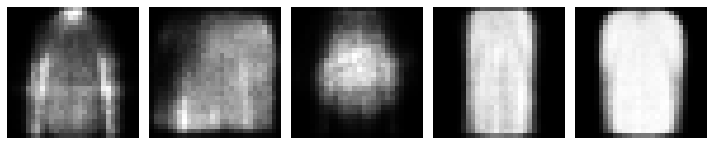

Train Epoch: 5 [batch: 0/465 (0%)]	Loss: 241.552841
Train Epoch: 5 [batch: 100/465 (22%)]	Loss: 250.440643
Train Epoch: 5 [batch: 200/465 (43%)]	Loss: 247.905396
Train Epoch: 5 [batch: 300/465 (65%)]	Loss: 249.438141
Train Epoch: 5 [batch: 400/465 (86%)]	Loss: 248.067673
====> Epoch: 5 Average loss: 248.7732


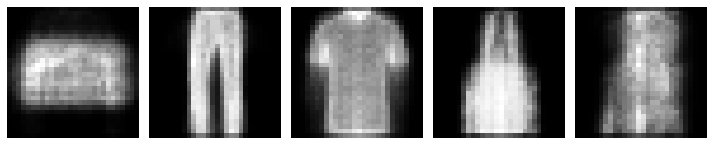

Training the SVM...
Conmputing error
---------- n=1000 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/461 (0%)]	Loss: 544.970276
Train Epoch: 1 [batch: 100/461 (22%)]	Loss: 314.431183
Train Epoch: 1 [batch: 200/461 (43%)]	Loss: 288.984589
Train Epoch: 1 [batch: 300/461 (65%)]	Loss: 298.200470
Train Epoch: 1 [batch: 400/461 (87%)]	Loss: 284.889526
====> Epoch: 1 Average loss: 311.3193


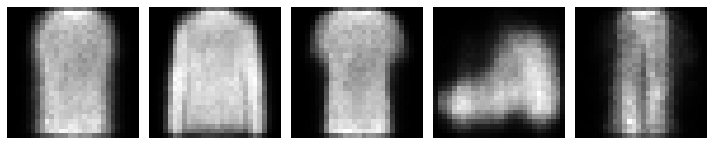

Train Epoch: 2 [batch: 0/461 (0%)]	Loss: 273.828064
Train Epoch: 2 [batch: 100/461 (22%)]	Loss: 274.407867
Train Epoch: 2 [batch: 200/461 (43%)]	Loss: 274.265350
Train Epoch: 2 [batch: 300/461 (65%)]	Loss: 255.123978
Train Epoch: 2 [batch: 400/461 (87%)]	Loss: 267.201111
====> Epoch: 2 Average loss: 265.3028


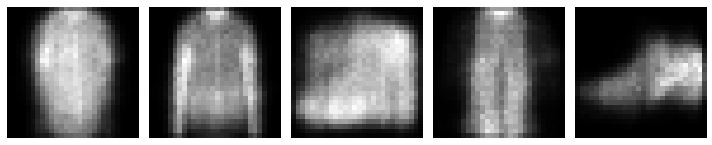

Train Epoch: 3 [batch: 0/461 (0%)]	Loss: 261.355286
Train Epoch: 3 [batch: 100/461 (22%)]	Loss: 244.665451
Train Epoch: 3 [batch: 200/461 (43%)]	Loss: 244.753738
Train Epoch: 3 [batch: 300/461 (65%)]	Loss: 254.941864
Train Epoch: 3 [batch: 400/461 (87%)]	Loss: 246.723373
====> Epoch: 3 Average loss: 256.4623


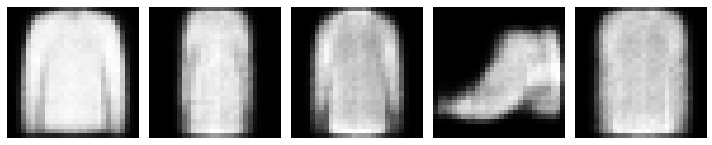

Train Epoch: 4 [batch: 0/461 (0%)]	Loss: 251.468246
Train Epoch: 4 [batch: 100/461 (22%)]	Loss: 258.922333
Train Epoch: 4 [batch: 200/461 (43%)]	Loss: 240.478485
Train Epoch: 4 [batch: 300/461 (65%)]	Loss: 249.581940
Train Epoch: 4 [batch: 400/461 (87%)]	Loss: 256.080994
====> Epoch: 4 Average loss: 251.6378


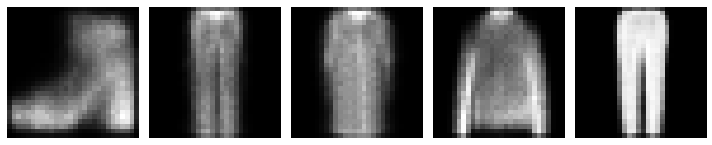

Train Epoch: 5 [batch: 0/461 (0%)]	Loss: 243.609573
Train Epoch: 5 [batch: 100/461 (22%)]	Loss: 256.675446
Train Epoch: 5 [batch: 200/461 (43%)]	Loss: 255.630157
Train Epoch: 5 [batch: 300/461 (65%)]	Loss: 239.178986
Train Epoch: 5 [batch: 400/461 (87%)]	Loss: 242.906326
====> Epoch: 5 Average loss: 248.5544


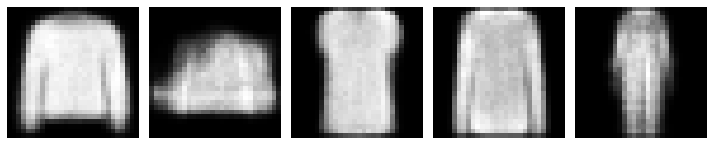

Training the SVM...
Conmputing error
---------- n=3000 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/446 (0%)]	Loss: 544.957275
Train Epoch: 1 [batch: 100/446 (22%)]	Loss: 305.021515
Train Epoch: 1 [batch: 200/446 (45%)]	Loss: 300.546509
Train Epoch: 1 [batch: 300/446 (67%)]	Loss: 301.961914
Train Epoch: 1 [batch: 400/446 (90%)]	Loss: 280.149872
====> Epoch: 1 Average loss: 312.1724


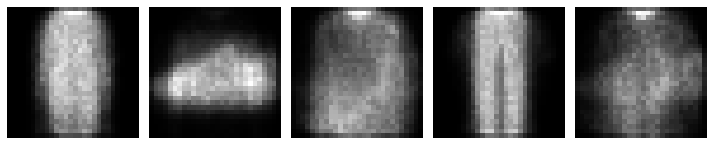

Train Epoch: 2 [batch: 0/446 (0%)]	Loss: 269.111237
Train Epoch: 2 [batch: 100/446 (22%)]	Loss: 266.317169
Train Epoch: 2 [batch: 200/446 (45%)]	Loss: 258.393738
Train Epoch: 2 [batch: 300/446 (67%)]	Loss: 272.235138
Train Epoch: 2 [batch: 400/446 (90%)]	Loss: 257.432007
====> Epoch: 2 Average loss: 267.1204


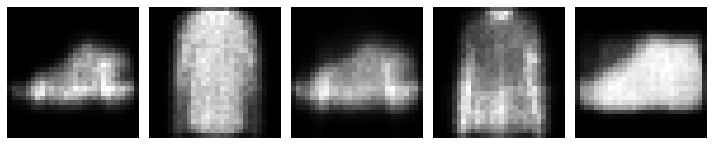

Train Epoch: 3 [batch: 0/446 (0%)]	Loss: 267.013611
Train Epoch: 3 [batch: 100/446 (22%)]	Loss: 255.974030
Train Epoch: 3 [batch: 200/446 (45%)]	Loss: 250.800934
Train Epoch: 3 [batch: 300/446 (67%)]	Loss: 259.799347
Train Epoch: 3 [batch: 400/446 (90%)]	Loss: 254.209564
====> Epoch: 3 Average loss: 257.3278


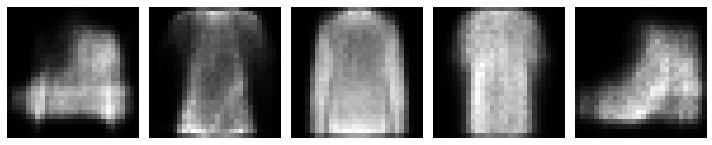

Train Epoch: 4 [batch: 0/446 (0%)]	Loss: 259.409851
Train Epoch: 4 [batch: 100/446 (22%)]	Loss: 245.293884
Train Epoch: 4 [batch: 200/446 (45%)]	Loss: 251.455292
Train Epoch: 4 [batch: 300/446 (67%)]	Loss: 254.672974
Train Epoch: 4 [batch: 400/446 (90%)]	Loss: 244.484177
====> Epoch: 4 Average loss: 251.8391


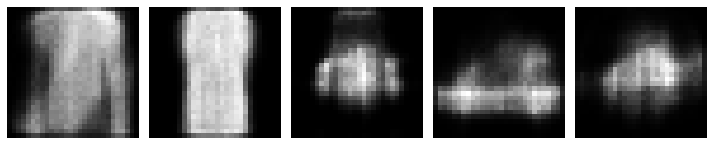

Train Epoch: 5 [batch: 0/446 (0%)]	Loss: 258.150818
Train Epoch: 5 [batch: 100/446 (22%)]	Loss: 245.756027
Train Epoch: 5 [batch: 200/446 (45%)]	Loss: 250.224960
Train Epoch: 5 [batch: 300/446 (67%)]	Loss: 246.647339
Train Epoch: 5 [batch: 400/446 (90%)]	Loss: 249.069000
====> Epoch: 5 Average loss: 248.8079


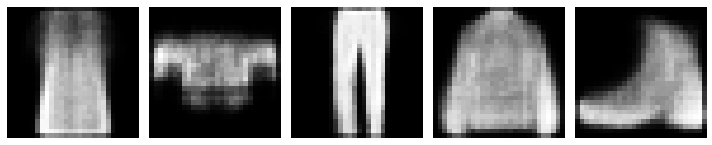

Training the SVM...
Conmputing error


In [73]:
results = {}
for n in [100, 600, 1_000, 3_000]:
    print('-'*10, f'n={n}', '-'*10)
    curr_error, curr_vae, curr_svm = m1_scheme(n, epochs=5)
    results[n] = curr_error, curr_vae, curr_svm

# Show Results

In [74]:
for n, (error, vae, svm) in results.items():
    print('-'*30)
    print(f'| {n} | {error}')

------------------------------
| 100 | 32.379999999999995
------------------------------
| 600 | 22.829999999999995
------------------------------
| 1000 | 22.019999999999996
------------------------------
| 3000 | 19.399999999999995
